**Alex Nelms**

MUSA-650 Homework 4

4/22/2022

 ## HW4 - EuroSAT Land Use and Land Cover Classification using Deep Learning
 
In this homework your task is to implement deep learning models to solve a typical problem in satellite imaging  using a benchmark dataset. The homework was designed to make you work on increasingly more complex models. We hope that the homework will be very helpful to improve your skills and knowledge in deep learning!


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os 
import pandas as pd
import numpy as np
import math
from skimage import io
import matplotlib.pyplot as plt

DIR = '/content/drive/MyDrive/Penn/MUSA-650/HW4'
DATA_DIR = 'eurosat/'

%cd {DIR}

/content/drive/MyDrive/Penn/MUSA-650/HW4


In [2]:
# get shape
def unflatten(array, include_channels=True, channels = 1):
  # shape initial
  n_samples = array.shape[0]
  flat_shape = array.shape[1]

  flat_shape = flat_shape/channels
  img_shape = int(math.sqrt(flat_shape))
  new_shape = (n_samples, img_shape, img_shape)
  if include_channels==True:
    new_shape += (channels,)

  return array.reshape(new_shape)

def csv_to_array(path):
  # import csv of image data 
  ## pre-flattened
  image_df = pd.read_csv(path)
  cols = [col for col in list(image_df) if 'Unnamed' not in col]
  image_df = image_df[cols]

  # list of shape index colnames
  icols = [col for col in list(image_df) if 'ass' not in col]
  # make array out of rgb dataframe
  image_arr = np.stack(image_df[icols].apply(list, axis=1))
  print('Shape: {}'.format(image_arr.shape))

  # array of classes of 
  classes = image_df['class'].values

  return image_arr, classes

### S1: Prepare Grey Data

- Visit the EuroSAT data description page and download the data: https://github.com/phelber/eurosat

- Convert each RGB image to grayscale and flatten the images into a data matrix (n x p: n = #samples, p = #pixels in each image)

- *I precleaned my data in a different ipynb ([GITHUB LINK](https://github.com/nelmsal/MUSA650_HW4_LandUseClassification/blob/main/HW4_dataclean.ipynb))*


In [190]:
# import csv of grey-scale image data
## csv is imported, flattened, & grey-scaled RGB eurosat images
grey_path = DATA_DIR + 'RGB/grey_flat.csv'
grey_arr, grey_classes = csv_to_array(grey_path)

# list of class labels
labels = list(set(grey_classes))
labels.sort()
labels_dict = {label:num for num,label in enumerate(labels)}

def correct_classes(classes, label_dict = labels_dict):
  classes = np.vectorize(labels_dict.get)(classes)
  classes = np.asarray(classes)#.astype('float32').reshape((-1,1))
  return classes

# grey classes to ints instead of strings
grey_classes = correct_classes(grey_classes)

Shape: (27000, 4096)


- Split the data into training (50%) and testing sets (50%), stratified on class labels (equal percentage of each class type in train and test sets).

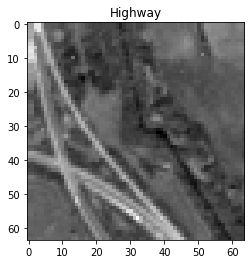

X train: (13500, 4096)
Y train: (13500, 10)


In [191]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, RMSprop
import keras

# SPLIT GREY DATAFRAME INTO 50/50 
## WITH STRATIFICATION ON THE CLASSES COL
X_train, X_test, y_train, y_test = train_test_split(
    grey_arr, grey_classes, 
    test_size=0.5, random_state=420, 
    stratify=grey_classes
    )

## Scale the data
scalar = MinMaxScaler()
scalar.fit(X_train)
X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)
#X_train = unflatten(scalar.transform(X_train))
#X_test = unflatten(scalar.transform(X_test))

# TEST PLOT
idx = 800
img = X_train[idx:idx+1,:]
img = unflatten(img).reshape((64,64))
img_label = labels[y_train[idx]]
plt.imshow(img, cmap='gray')
plt.title(img_label)
plt.show()

# convert class vectors to binary class matrices
y_train = keras.utils.np_utils.to_categorical(y_train, len(labels))
y_test = keras.utils.np_utils.to_categorical(y_test, len(labels))

input_shape = X_train.shape[1:]
print('X train: {}'. format(X_train.shape))
print('Y train: {}'. format(y_train.shape))

### S2: 1 Layer

- Implement a first deep learning model (M.1) using a fully connected network with a single fully connected layer (i.e: input layer + fully connected layer as the output layer). 

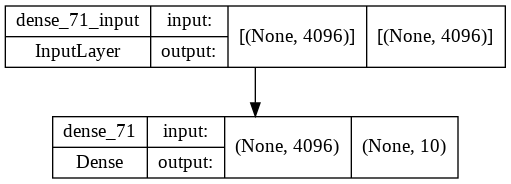

In [192]:
# create model
m1_model = Sequential()

# add fully connected layer as output 
m1_model.add(Dense(len(labels), activation='softmax', input_shape=input_shape))

## Compile the model
OPT = RMSprop(learning_rate=0.001) #Adam(learning_rate=0.001)
m1_model.compile(loss='categorical_crossentropy', optimizer=OPT, metrics=['accuracy'])

# plot layers
plot_model(m1_model, show_shapes=True, show_layer_names=True)

In [193]:
B_SIZE = 64
NUM_EPOCH = 15

# FIT THE MODEL
m1_1lyr_grey_model = m1_model.fit(
    X_train, y_train, 
    batch_size=B_SIZE, 
    epochs=NUM_EPOCH, shuffle=True, 
    validation_data=(X_test, y_test)
    )

Epoch 1/15
211/211 [==============================] - 2s 7ms/step - loss: 2.4582 - accuracy: 0.1305 - val_loss: 2.2267 - val_accuracy: 0.1539
Epoch 2/15
211/211 [==============================] - 1s 7ms/step - loss: 2.3551 - accuracy: 0.1616 - val_loss: 2.3987 - val_accuracy: 0.1290
Epoch 3/15
211/211 [==============================] - 1s 7ms/step - loss: 2.3199 - accuracy: 0.1822 - val_loss: 2.1955 - val_accuracy: 0.2119
Epoch 4/15
211/211 [==============================] - 2s 8ms/step - loss: 2.2867 - accuracy: 0.1932 - val_loss: 2.2704 - val_accuracy: 0.2021
Epoch 5/15
211/211 [==============================] - 2s 8ms/step - loss: 2.2606 - accuracy: 0.2119 - val_loss: 2.1903 - val_accuracy: 0.1731
Epoch 6/15
211/211 [==============================] - 2s 7ms/step - loss: 2.2250 - accuracy: 0.2296 - val_loss: 2.1160 - val_accuracy: 0.2349
Epoch 7/15
211/211 [==============================] - 2s 8ms/step - loss: 2.2132 - accuracy: 0.2373 - val_loss: 2.0868 - val_accuracy: 0.2550
Epoch 

Q2.1: Calculate classification accuracy on the test data.

Accuracy: 13.05%


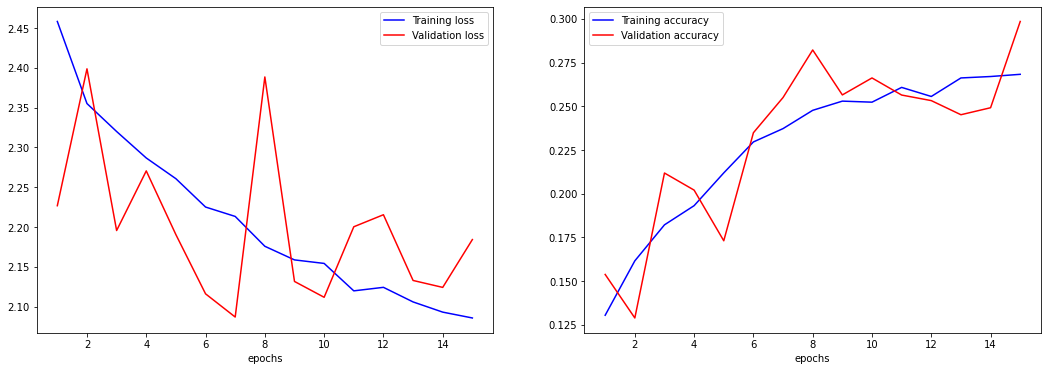

In [194]:
def plot_loss_acc(fitted_model, num_epoch = NUM_EPOCH):
  import matplotlib.pyplot as plt
  fig, ax = plt.subplots(1,2, figsize=[18,6])
  ax[0].plot(range(1, NUM_EPOCH+1), fitted_model.history['loss'], c='blue', label='Training loss')
  ax[0].plot(range(1, NUM_EPOCH+1), fitted_model.history['val_loss'], c='red', label='Validation loss')
  ax[0].legend()
  ax[0].set_xlabel('epochs')

  ax[1].plot(range(1, NUM_EPOCH+1), fitted_model.history['accuracy'], c='blue', label='Training accuracy')
  ax[1].plot(range(1, NUM_EPOCH+1), fitted_model.history['val_accuracy'], c='red', label='Validation accuracy')
  ax[1].legend()
  ax[1].set_xlabel('epochs')

plot_loss_acc(m1_1lyr_grey_model, NUM_EPOCH)

classification_accuracy = min(m1_1lyr_grey_model.history['accuracy'])
print( 'Accuracy: {0:.2%}'.format(classification_accuracy))

### S3: 2 Layers

- Implement a second deep learning model (M.2) adding an additional fully connected hidden layer (with an arbitrary number of nodes) to the previous model. 

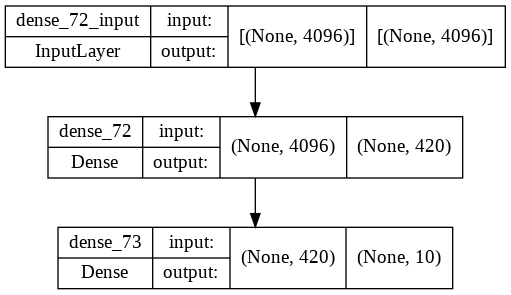

In [195]:
# create model
m2_model = Sequential()

# add one dense layer
## with relu to activate and achieve a non-linear activation
m2_model.add(Dense(420, activation='relu', input_shape=input_shape))

# add second dense layer
## with softmax as it will normalize the output
m2_model.add(Dense(len(labels), activation='softmax'))

## Compile the model
OPT = RMSprop(learning_rate=0.001) #Adam(learning_rate=0.001)
m2_model.compile(loss='categorical_crossentropy', optimizer=OPT, metrics=['accuracy'])

# plot layers
plot_model(m2_model, show_shapes=True, show_layer_names=True)

In [196]:
B_SIZE = 64
NUM_EPOCH = 15

# FIT THE MODEL
m2_2lyr_grey_model = m2_model.fit(
    X_train, y_train, 
    batch_size=B_SIZE, 
    epochs=NUM_EPOCH, shuffle=True, 
    validation_data=(X_test, y_test)
    )

Epoch 1/15
211/211 [==============================] - 7s 31ms/step - loss: 2.6989 - accuracy: 0.1299 - val_loss: 2.4579 - val_accuracy: 0.1016
Epoch 2/15
211/211 [==============================] - 6s 30ms/step - loss: 2.2124 - accuracy: 0.1706 - val_loss: 2.1635 - val_accuracy: 0.1949
Epoch 3/15
211/211 [==============================] - 6s 30ms/step - loss: 2.1101 - accuracy: 0.2213 - val_loss: 2.1409 - val_accuracy: 0.1650
Epoch 4/15
211/211 [==============================] - 6s 29ms/step - loss: 2.0327 - accuracy: 0.2613 - val_loss: 1.9814 - val_accuracy: 0.2531
Epoch 5/15
211/211 [==============================] - 6s 29ms/step - loss: 1.9702 - accuracy: 0.2844 - val_loss: 1.9211 - val_accuracy: 0.3013
Epoch 6/15
211/211 [==============================] - 6s 30ms/step - loss: 1.9122 - accuracy: 0.3006 - val_loss: 1.9013 - val_accuracy: 0.3050
Epoch 7/15
211/211 [==============================] - 6s 29ms/step - loss: 1.8638 - accuracy: 0.3093 - val_loss: 1.8176 - val_accuracy: 0.3371

Q3.1: Calculate classification accuracy on the test data.  

Accuracy: 37.92%


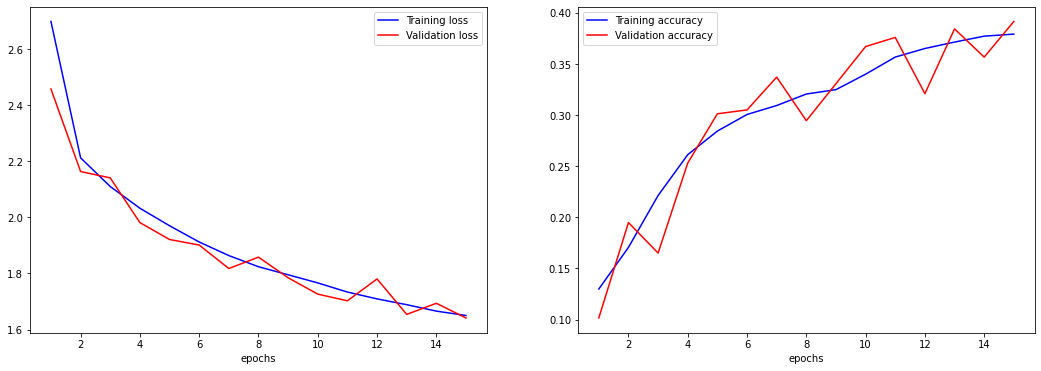

In [197]:
plot_loss_acc(m2_2lyr_grey_model, NUM_EPOCH)

classification_accuracy = max(m2_2lyr_grey_model.history['accuracy'])
print( 'Accuracy: {0:.2%}'.format(classification_accuracy))

### S4: 4 Layers

- Implement a third deep learning model (M.3) adding two additional fully connected hidden layers (with arbitrary number of nodes) for a total of four, as well as drop-out layers to the previous model.

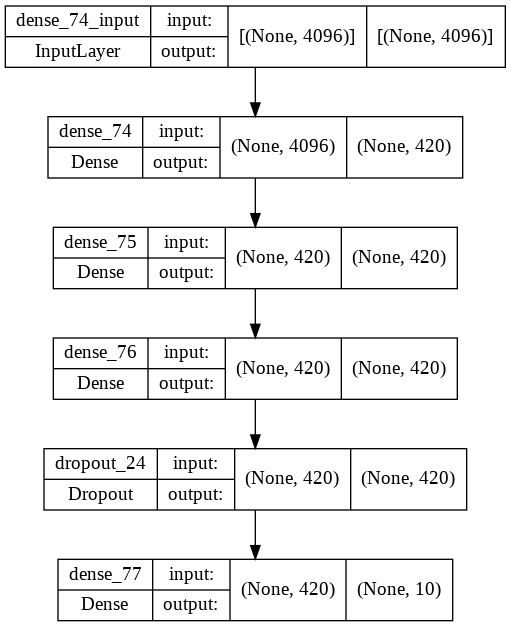

In [198]:
# create model
m3_model = Sequential()

# add one dense layer
m3_model.add(Dense(420, activation='relu', input_shape=input_shape))


# add second dense layer
m3_model.add(Dense(420, activation='relu'))

# add third dense layer
m3_model.add(Dense(420, activation='relu'))
## with a layer to dropout a set of training data to make neurons less sensitive & the model more general
m3_model.add(Dropout(0.2))

# add fourth dense layer
m3_model.add(Dense(len(labels), activation='softmax'))

## Compile the model
OPT = RMSprop(learning_rate=0.001)
m3_model.compile(loss='categorical_crossentropy', optimizer=OPT, metrics=['accuracy'])

# plot layers
plot_model(m3_model, show_shapes=True, show_layer_names=True)

In [199]:
B_SIZE = 64
NUM_EPOCH = 15

# FIT THE MODEL
m3_4lyr_grey_model = m3_model.fit(
    X_train, y_train, 
    batch_size=B_SIZE, 
    epochs=NUM_EPOCH, shuffle=True, 
    validation_data=(X_test, y_test)
    )

Epoch 1/15
211/211 [==============================] - 9s 38ms/step - loss: 2.2361 - accuracy: 0.1849 - val_loss: 1.9521 - val_accuracy: 0.2744
Epoch 2/15
211/211 [==============================] - 8s 37ms/step - loss: 1.8733 - accuracy: 0.2929 - val_loss: 1.7198 - val_accuracy: 0.3649
Epoch 3/15
211/211 [==============================] - 8s 40ms/step - loss: 1.7912 - accuracy: 0.3194 - val_loss: 1.7391 - val_accuracy: 0.3379
Epoch 4/15
211/211 [==============================] - 9s 44ms/step - loss: 1.7491 - accuracy: 0.3384 - val_loss: 1.7511 - val_accuracy: 0.3362
Epoch 5/15
211/211 [==============================] - 9s 45ms/step - loss: 1.7152 - accuracy: 0.3496 - val_loss: 2.0027 - val_accuracy: 0.2950
Epoch 6/15
211/211 [==============================] - 9s 44ms/step - loss: 1.6869 - accuracy: 0.3626 - val_loss: 1.7006 - val_accuracy: 0.3518
Epoch 7/15
211/211 [==============================] - 9s 44ms/step - loss: 1.6631 - accuracy: 0.3664 - val_loss: 1.6395 - val_accuracy: 0.3791

Q4.1: Calculate classification accuracy on the test data.

Accuracy: 40.92%


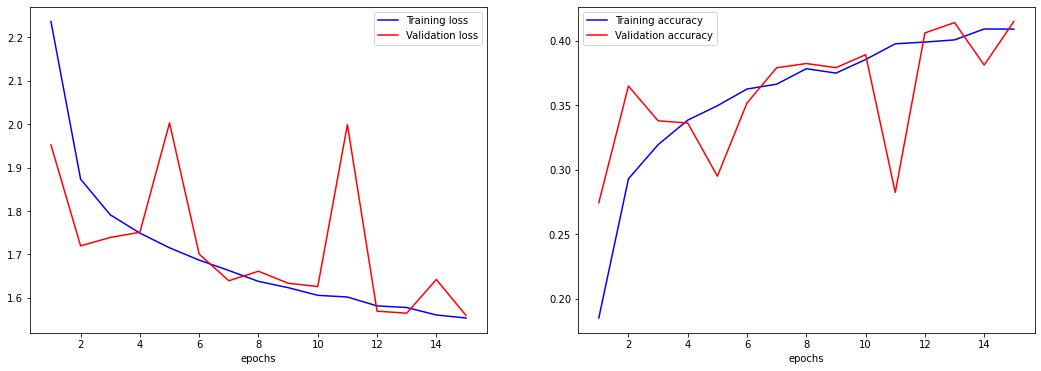

In [200]:
plot_loss_acc(m3_4lyr_grey_model, NUM_EPOCH)

classification_accuracy = max(m3_4lyr_grey_model.history['accuracy'])
print( 'Accuracy: {0:.2%}'.format(classification_accuracy))

Q4.2: Compare against previous models. Which model was the "best"? Why?


*   *The **M3 Model** (with 4 dense layers) appears like the best model as it immediately had a testing accuracy above 25% then ended up above 40%*
*   *The M3 Model was likely immediately better due to the extra neurons & drop out layer. The extra layers allowed more opportunities to group features. The dropout layer progressively raised the model's accuracy as the changing training data made it generalized.*
*   *On the otherhand, the S3 Model had a competitively high accucuracy with 2 layers. But the model had a higher variance in accuracy due to it being less generalized.*



In [201]:
# make comparision plots
import matplotlib.cm as cm
from matplotlib.colors import rgb2hex, Normalize

# get color from cmap for values
def color_map_color(values, cmap_name='Wistia'):
    norm = Normalize(vmin=0, vmax=max(values))
    cmap = cm.get_cmap(cmap_name)
    def get_col(value):
      return rgb2hex(cmap(norm(abs(value)))[:3])
    colors = [get_col(c) for c in values]
    return colors
# get colors for every plot and cmap
def get_colors_list(plot_count, item_count, cmaps=['Blues','Oranges','Greens','Reds']):
  plot_indexes = list(range(plot_count))
  item_indexes = list(range(item_count))
  plot_colors = []
  for num_plot in plot_indexes:
    cmap = cmaps[num_plot]
    plot_colors.append(color_map_color(item_indexes, cmap))
  return plot_colors
# add each model's colors to the end of model plot lists
def add_color_list(plot_lists, plot_count, skip=0):
  plot_colors = get_colors_list(plot_count, len(plot_lists)+skip)
  return [plot_list+[[
              plot_color_list[idx+skip] for plot_color_list in plot_colors     
                    ]] for idx, plot_list in enumerate(plot_lists)]
# get history for each model then append to plot lists
def add_model_history(plot_lists, history_types = ['loss', 'val_loss', 'accuracy', 'val_accuracy']):
  new_list = []
  for idx, plot_list in enumerate(plot_lists):
    model_hist = plot_list[0]
    other_list = plot_list[1:]
    model_hists = [model_hist.history[hist_type] for hist_type in history_types]
    new_list.append((model_hists, other_list[0], other_list[1]))
  return new_list

# list of models & labeks
plotting_models = [
                   [m1_1lyr_grey_model, 'M1 (1 lyr)'],
                   [m2_2lyr_grey_model, 'M2 (2 lyr)'],
                   [m3_4lyr_grey_model, 'M3 (4 lyr)']
]
# list of model histories to evaluate
history_types = ['loss','val_loss', 'accuracy', 'val_accuracy']
plotting_models = add_color_list(plotting_models, 4, skip=1)
plotting_models = add_model_history(plotting_models, history_types)

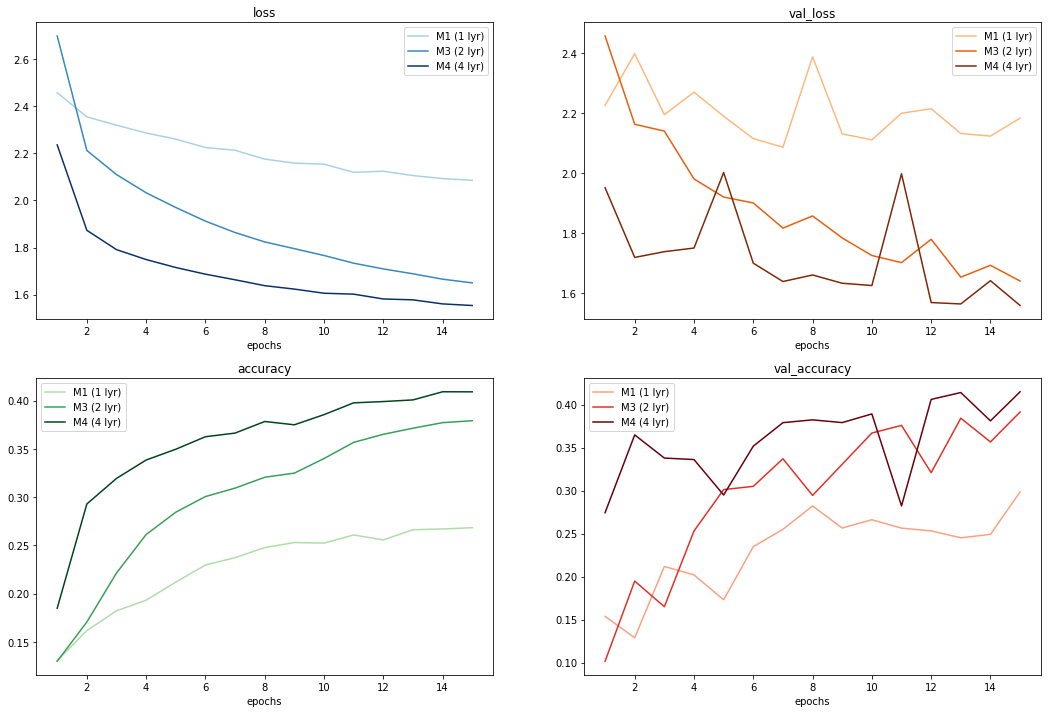

In [202]:
def plot_single_model(axis, model_history, plot_nums=NUM_EPOCH, color='blue', label='Training loss'):
  axis.plot(range(1, plot_nums+1), model_history, c=color, label=label)

def plots_loss_acc(model_lists):
  import matplotlib.pyplot as plt
  cols, rows = 2, 2
  axes = []
  [[axes.append((c,r)) for r in range(rows)] for c  in range(cols)]
  axis_count = len(axes)
  fig, ax = plt.subplots(cols, rows, figsize=[18,12])

  for (models, label, colors) in model_lists:
    for axis_num, (model_history, color, (col,row)) in enumerate(zip(models, colors, axes)):
      plot_single_model(ax[col, row], list(model_history), color=color, label=label)

  for history_type, (col,row) in zip(history_types, axes):
    ax[col, row].legend()
    ax[col, row].set_xlabel('epochs')
    ax[col, row].set_title(history_type)
  
plots_loss_acc(plotting_models)

### S5: RGB w/ Conv2D

- Take the original RGB images and do not vectorize them. Use these images as the data input for the following models (M.4 and M.5).

In [206]:
# get csv of rgb data 
# size 64x64x3 flattened to 12288
rgb_path = 'eurosat/RGB/RGB_flat.csv'
rgb_arr, rgb_classes = csv_to_array(rgb_path)
rgb_classes = correct_classes(rgb_classes)

Shape: (27000, 12288)


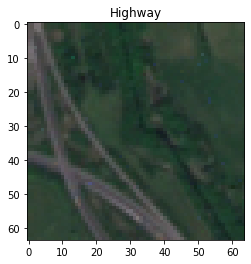

X train: (13500, 64, 64, 3)
Y train: (13500, 10)


In [210]:
# SPLIT GREY DATAFRAME INTO 50/50 
## WITH STRATIFICATION ON THE CLASSES COL
X_train_rgb, X_test_rgb, y_train_rgb, y_test_rgb = train_test_split(
    rgb_arr, rgb_classes, 
    test_size=0.5, random_state=420, 
    stratify=rgb_classes
    )

## Scale the data
scalar = MinMaxScaler()
scalar.fit(X_train_rgb)
X_train_rgb = unflatten(scalar.transform(X_train_rgb), channels=3)
X_test_rgb = unflatten(scalar.transform(X_test_rgb), channels=3)

# TEST PLOT
idx = 800
img = X_train_rgb[idx:idx+1,:]
img = img.reshape((64,64,3))
img_label = labels[y_train_rgb[idx]]
plt.imshow(img)
plt.title(img_label)
plt.show()

# convert class vectors to binary class matrices
y_train_rgb = keras.utils.np_utils.to_categorical(y_train_rgb, len(labels))
y_test_rgb = keras.utils.np_utils.to_categorical(y_test_rgb, len(labels))

rgb_input_shape = X_train_rgb.shape[1:]
print('X train: {}'. format(X_train_rgb.shape))
print('Y train: {}'. format(y_train_rgb.shape))

- Implement a fourth CNN model (M.4) that includes the following layers: Conv2D, MaxPooling2D, Dropout, Flatten, Dense. 

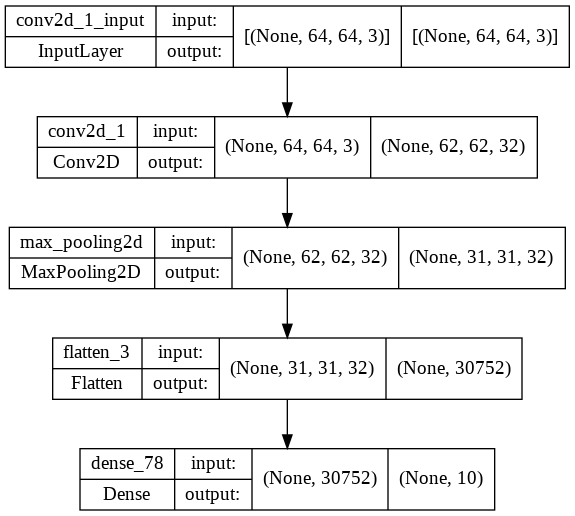

In [211]:
# create model
m4_model = Sequential()

# add convolution layer
## 3x3 kernel to filter through the data
m4_model.add(Conv2D(32, activation='relu', input_shape=rgb_input_shape, 
                    strides=(1,1), 
                    kernel_size=(3, 3)))
# add max pooling
## downsamples the input data
m4_model.add(MaxPooling2D(pool_size=(2, 2)))
# flatten out matrix
m4_model.add(Flatten())
# dense into output
m4_model.add(Dense(len(labels), activation='softmax'))

## Compile the model
OPT = RMSprop(learning_rate=0.001) #Adam(learning_rate=0.001)
m4_model.compile(loss='categorical_crossentropy', optimizer=OPT, metrics=['accuracy'])

# plot layers
plot_model(m4_model, show_shapes=True, show_layer_names=True)

In [212]:
B_SIZE = 64
NUM_EPOCH = 15

# FIT THE MODEL
m4_1lyr_rgb_model = m4_model.fit(
    X_train_rgb, y_train_rgb, 
    batch_size=B_SIZE, 
    epochs=NUM_EPOCH, shuffle=True, 
    validation_data=(X_test_rgb, y_test_rgb)
    )

Epoch 1/15
211/211 [==============================] - 25s 113ms/step - loss: 1.3719 - accuracy: 0.5110 - val_loss: 1.1617 - val_accuracy: 0.5663
Epoch 2/15
211/211 [==============================] - 24s 115ms/step - loss: 0.9779 - accuracy: 0.6561 - val_loss: 0.9206 - val_accuracy: 0.6635
Epoch 3/15
211/211 [==============================] - 21s 101ms/step - loss: 0.8533 - accuracy: 0.7009 - val_loss: 0.8799 - val_accuracy: 0.6810
Epoch 4/15
211/211 [==============================] - 22s 102ms/step - loss: 0.7776 - accuracy: 0.7299 - val_loss: 0.8635 - val_accuracy: 0.7000
Epoch 5/15
211/211 [==============================] - 21s 101ms/step - loss: 0.7050 - accuracy: 0.7596 - val_loss: 1.0139 - val_accuracy: 0.6678
Epoch 6/15
211/211 [==============================] - 22s 104ms/step - loss: 0.6470 - accuracy: 0.7845 - val_loss: 0.7320 - val_accuracy: 0.7447
Epoch 7/15
211/211 [==============================] - 22s 105ms/step - loss: 0.5964 - accuracy: 0.8017 - val_loss: 0.8673 - val_ac

Q5.1: Calculate classification accuracy on the test data.

Accuracy: 89.16%


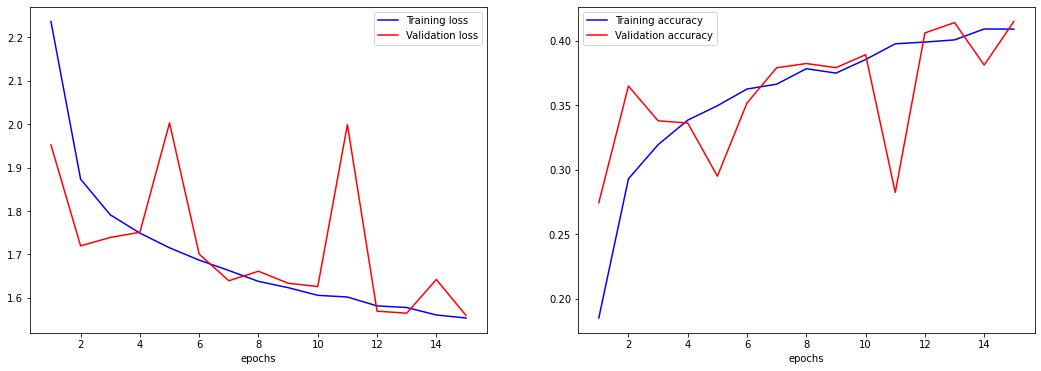

In [213]:
plot_loss_acc(m4_1lyr_grey_model, NUM_EPOCH)

classification_accuracy = max(m4_1lyr_rgb_model.history['accuracy'])
print( 'Accuracy: {0:.2%}'.format(classification_accuracy))

Q5.2: Compare against previous models. Which model was the "best"? Why?


*   *Oh, its so hard to pick which model is the best based on the accuracy.*
*   *It's definitely Model 4 though.*
*   *Model 4 has a significant increase in accuracy because the Conv2 actually applies the spatial factor of the raster. The MaxPooling can then downsample the data to get better classification.*

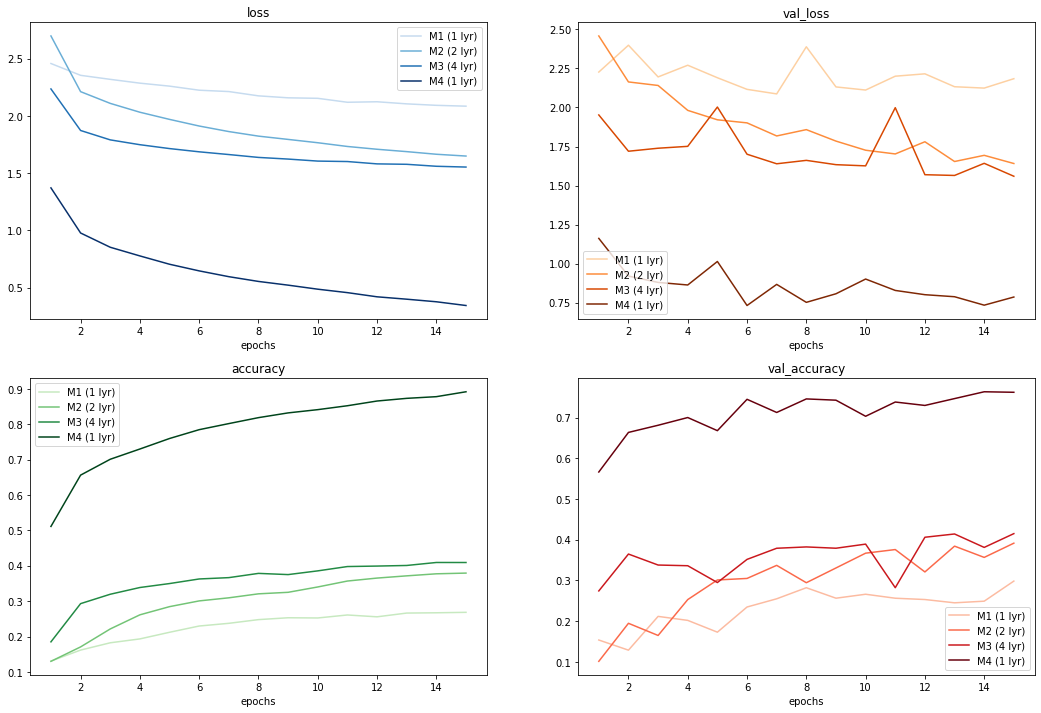

In [214]:
# list of models & labeks
plotting_models = [
                   [m1_1lyr_grey_model, 'M1 (1 lyr)'],
                   [m2_2lyr_grey_model, 'M2 (2 lyr)'],
                   [m3_4lyr_grey_model, 'M3 (4 lyr)'],
                   [m4_1lyr_rgb_model, 'M4 (1 lyr)']
]
# list of model histories to evaluate
history_types = ['loss','val_loss', 'accuracy', 'val_accuracy']
plotting_models = add_color_list(plotting_models, 4, skip=1)
plotting_models = add_model_history(plotting_models, history_types)
plots_loss_acc(plotting_models)

### S6: RGB w/ U-Net

- Using RGB images from S5, implement a fifth deep learning model (M.5) targeting accuracy that will outperform all previous models. You are free to use any tools and techniques, as well as pre-trained models for transfer 
learning. 



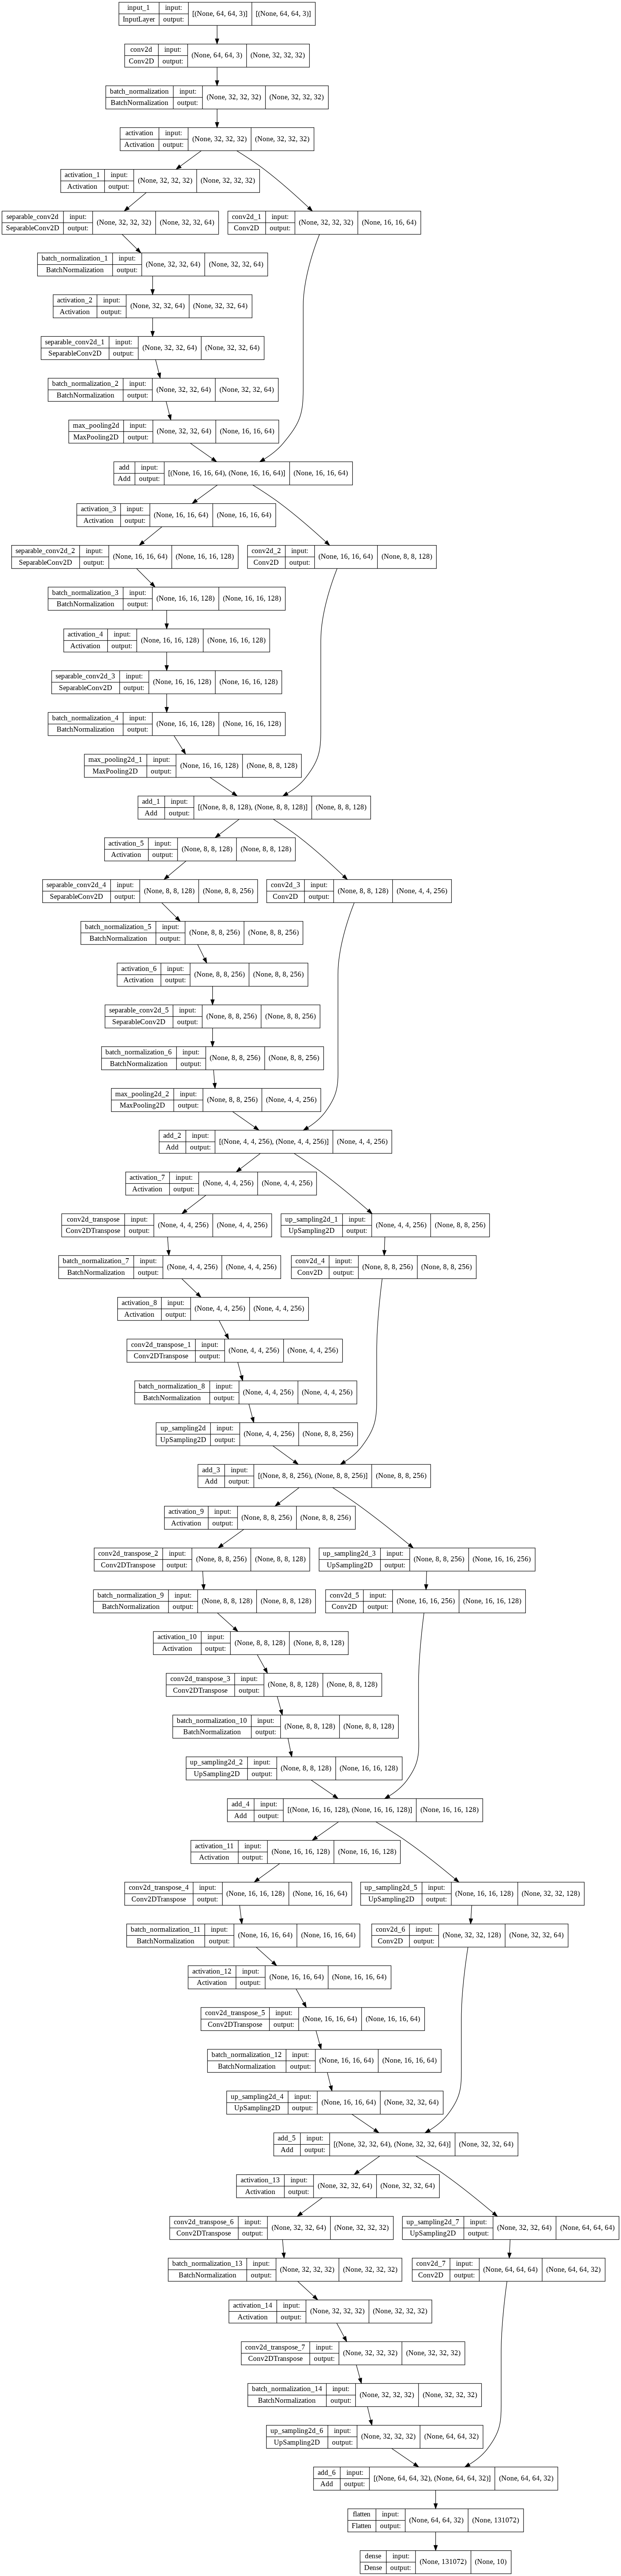

In [219]:
from tensorflow.keras import layers


def get_unet_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size)

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    #outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)
    
    # flatten out matrix
    x = layers.Flatten()(x)
    # dense into output
    outputs = Dense(len(labels), activation='softmax')(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
m5_model = get_unet_model(rgb_input_shape, len(labels))

## Compile the model
OPT = RMSprop(learning_rate=0.001) #Adam(learning_rate=0.001)
m5_model.compile(loss='categorical_crossentropy', optimizer=OPT, metrics=['accuracy'])

# plot layers
plot_model(m5_model, show_shapes=True, show_layer_names=True)

In [223]:
B_SIZE = 64
NUM_EPOCH = 15

# FIT THE MODEL
#m5_unet_rgb_model = m5_model.fit(
    X_train_rgb, y_train_rgb, 
    batch_size=B_SIZE, 
    epochs=NUM_EPOCH, shuffle=True, 
    validation_data=(X_test_rgb, y_test_rgb)
    )

Epoch 1/15
211/211 [==============================] - 420s 2s/step - loss: 15.9598 - accuracy: 0.4698 - val_loss: 7.3619 - val_accuracy: 0.1273
Epoch 2/15
211/211 [==============================] - 411s 2s/step - loss: 7.9769 - accuracy: 0.5444 - val_loss: 2.5391 - val_accuracy: 0.3899
Epoch 3/15
211/211 [==============================] - 399s 2s/step - loss: 4.9058 - accuracy: 0.5785 - val_loss: 1.7119 - val_accuracy: 0.6096
Epoch 4/15
211/211 [==============================] - 385s 2s/step - loss: 4.5907 - accuracy: 0.5896 - val_loss: 15.8394 - val_accuracy: 0.3893
Epoch 5/15
211/211 [==============================] - 406s 2s/step - loss: 3.3978 - accuracy: 0.6294 - val_loss: 1.7976 - val_accuracy: 0.6681
Epoch 6/15
211/211 [==============================] - 397s 2s/step - loss: 2.3404 - accuracy: 0.6706 - val_loss: 4.0610 - val_accuracy: 0.4717
Epoch 7/15
211/211 [==============================] - 400s 2s/step - loss: 2.1504 - accuracy: 0.6859 - val_loss: 26.3950 - val_accuracy: 0.5

Q6.1: Describe the model you built, and why you chose it.
*   *I'm implementing a U-Net model that I stole from this [keras documentation](https://keras.io/examples/vision/oxford_pets_image_segmentation/)*
*   *I'm using a U-Net Xception-style model because Professor Guray & people on the internet recommend it for semantic segmentation*
*   *I realize that I should have used a simpler model instead of one that took an hour to fit.*

Q6.2: Calculate classification accuracy on the test data.

Accuracy: 80.95%


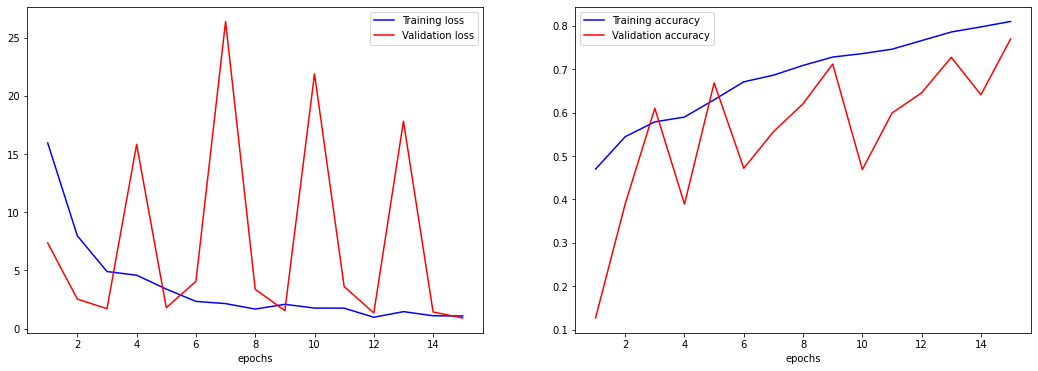

In [224]:
plot_loss_acc(m5_unet_rgb_model, NUM_EPOCH)

classification_accuracy = max(m5_unet_rgb_model.history['accuracy'])
print( 'Accuracy: {0:.2%}'.format(classification_accuracy))

Q6.3: Compare against previous models. Which model was the "best"? Why?

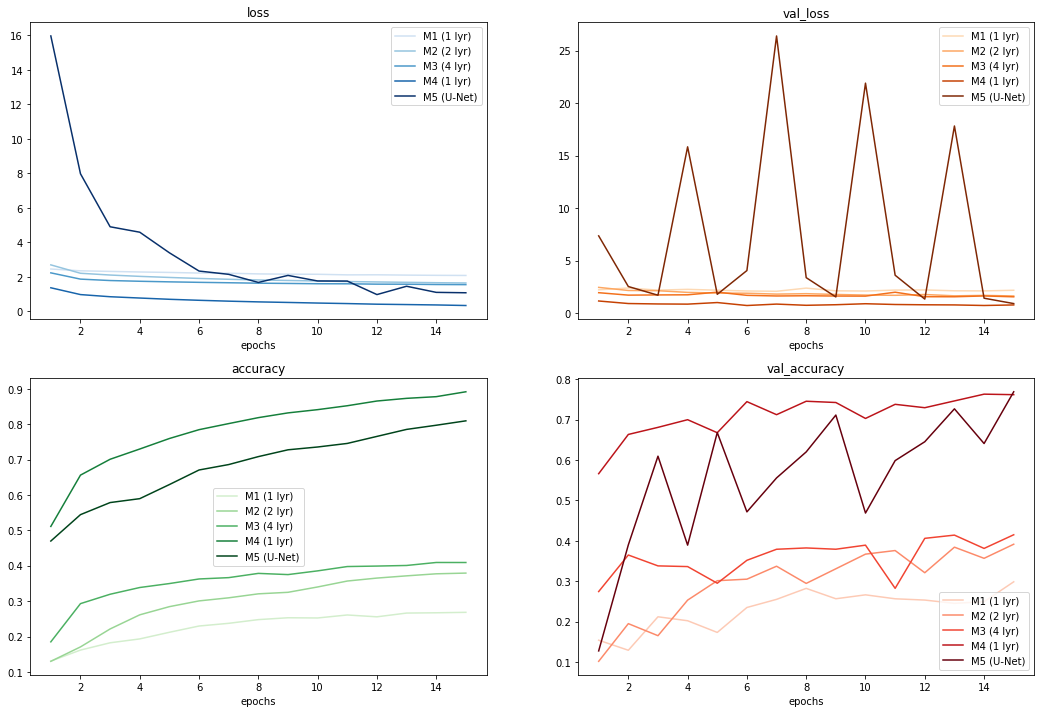

In [225]:
# list of models & labeks
plotting_models = [
                   [m1_1lyr_grey_model, 'M1 (1 lyr)'],
                   [m2_2lyr_grey_model, 'M2 (2 lyr)'],
                   [m3_4lyr_grey_model, 'M3 (4 lyr)'],
                   [m4_1lyr_rgb_model, 'M4 (1 lyr)'],
                   [m5_unet_rgb_model, 'M5 (U-Net)'],
]
# list of model histories to evaluate
history_types = ['loss','val_loss', 'accuracy', 'val_accuracy']
plotting_models = add_color_list(plotting_models, 4, skip=1)
plotting_models = add_model_history(plotting_models, history_types)
plots_loss_acc(plotting_models)

Q6.4: What are the two classes with the highest labeling error? Explain using data and showing mis-classified examples.

### S7: Multispectral

- Apply your best model on multispectral images. You may use whichever image channels you wish, so long as you use more than just RGB (although you are not required to use any color channels).
- *It took 4+ hours just to turn the MS images into arrays* *(see pic below for time reference)*

![alt text](process_time.png)

- *I finished most of HW4 before Sunday, April 24th. But most of sunday was taken up by pre-cleaning the MS dataset into a csv*
- *One the MS dataset downloaded at like 4am, the S7 code couldn't process because it kept crashing the computer*

In [ ]:
# get csv of rgb data 
# size 64x64x3 flattened to 12288
ms_path = 'eurosat/MS/MS_flat.csv'
ms_arr, ms_classes = csv_to_array(ms_path)

In [ ]:
# list of class labels
labels = list(set(ms_classes))
labels.sort()
labels_dict = {label:num for num,label in enumerate(labels)}

def correct_classes(classes, label_dict = labels_dict):
  classes = np.vectorize(labels_dict.get)(classes)
  classes = np.asarray(classes)#.astype('float32').reshape((-1,1))
  return classes

# grey classes to ints instead of strings
grey_classes = correct_classes(grey_classes)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, RMSprop
import keras

# SPLIT GREY DATAFRAME INTO 50/50 
## WITH STRATIFICATION ON THE CLASSES COL
X_train_ms, X_test_ms, y_train_ms, y_test_ms = train_test_split(
    rgb_arr, rgb_classes, 
    test_size=0.5, random_state=420, 
    stratify=rgb_classes
    )

## Scale the data
scalar = MinMaxScaler()
scalar.fit(X_train_ms)
X_train_ms = unflatten(scalar.transform(X_train_ms), channels=3)
X_test_ms = unflatten(scalar.transform(X_test_ms), channels=3)

# TEST PLOT
idx = 800
img = X_train_ms[idx:idx+1,:]
img = img.reshape((64,64,13))
img_label = labels[y_train_ms[idx]]
plt.imshow(img)
plt.title(img_label)
plt.show()

# convert class vectors to binary class matrices
y_train_ms = keras.utils.np_utils.to_categorical(y_train_ms, len(labels))
y_test_ms = keras.utils.np_utils.to_categorical(y_test_ms, len(labels))

ms_input_shape = X_train_ms.shape[1:]
print('X train: {}'. format(X_train_ms.shape))
print('Y train: {}'. format(y_train_ms.shape))

*    *Using the M4 model as it was very accurate without the long processing times*

In [ ]:
# create model
m6_model = Sequential()

# add convolution layer
## 3x3 kernel to filter through the data
m6_model.add(Conv2D(32, activation='relu', input_shape=ms_input_shape, 
                    strides=(1,1), 
                    kernel_size=(3, 3)))
# add max pooling
## downsamples the input data
m6_model.add(MaxPooling2D(pool_size=(2, 2)))
# flatten out matrix
m6_model.add(Flatten())
# dense into output
m6_model.add(Dense(len(labels), activation='softmax'))

## Compile the model
OPT = RMSprop(learning_rate=0.001) #Adam(learning_rate=0.001)
m6_model.compile(loss='categorical_crossentropy', optimizer=OPT, metrics=['accuracy'])

# plot layers
plot_model(m6_model, show_shapes=True, show_layer_names=True)

In [ ]:
B_SIZE = 64
NUM_EPOCH = 15

# FIT THE MODEL
m6_1lyr_ms_model = m6_model.fit(
    X_train_ms, y_train_ms, 
    batch_size=B_SIZE, 
    epochs=NUM_EPOCH, shuffle=True, 
    validation_data=(X_test_ms, y_test_ms)
    )

Q7.1: Calculate classification accuracy on the test data.

In [ ]:
plot_loss_acc(m6_1lyr_ms_model, NUM_EPOCH)

classification_accuracy = max(m6_1lyr_ms_model.history['accuracy'])
print( 'Accuracy: {0:.2%}'.format(classification_accuracy))

Q7.2: Compare against results using RGB images.

In [ ]:
# list of models & labeks
plotting_models = [
                   [m1_1lyr_grey_model, 'M1 (1 lyr)'],
                   [m2_2lyr_grey_model, 'M2 (2 lyr)'],
                   [m3_4lyr_grey_model, 'M3 (4 lyr)'],
                   [m4_1lyr_rgb_model, 'M4 (1 lyr)'],
                   [m5_unet_rgb_model, 'M5 (U-Net)'],
                   [m6_1lyr_ms_model, 'M6 (1 lyr']
]
# list of model histories to evaluate
history_types = ['loss','val_loss', 'accuracy', 'val_accuracy']
plotting_models = add_color_list(plotting_models, 4, skip=1)
plotting_models = add_model_history(plotting_models, history_types)
plots_loss_acc(plotting_models)